<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research_srgan_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libraries

In [12]:
import glob
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale
from skimage.metrics import peak_signal_noise_ratio as psnr

from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# importing dataset

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [14]:
pip install opencv-python-headless numpy

# Image enhancement using Traditional Method

#Nearest Neighbor Interpolation




In [15]:
def nearest_neighbor_interpolation(image, scale_factor):
    original_height, original_width = image.shape[:2]
    new_height, new_width = int(original_height * scale_factor), int(original_width * scale_factor)

    # Create an empty array for the new image
    upscaled_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)

    for i in range(new_height):
        for j in range(new_width):
            # Find the nearest neighbor in the original image
            orig_x = int(j / scale_factor)
            orig_y = int(i / scale_factor)
            upscaled_image[i, j] = image[orig_y, orig_x]

    return upscaled_image

# Path to the image dataset
dataset_path = '/content/drive/MyDrive/research_dataset/BSD100'

# List all files in the dataset directory
image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

# Select a random image from the dataset
random_image_file = random.choice(image_files)
image_path = os.path.join(dataset_path, random_image_file)

# Load the selected image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Perform Nearest Neighbor Interpolation
scale_factor = 2
upscaled_image = nearest_neighbor_interpolation(image, scale_factor)

# Resize the original image to match the upscaled image size for PSNR calculation
resized_original_image = cv2.resize(image, (upscaled_image.shape[1], upscaled_image.shape[0]), interpolation=cv2.INTER_LINEAR)

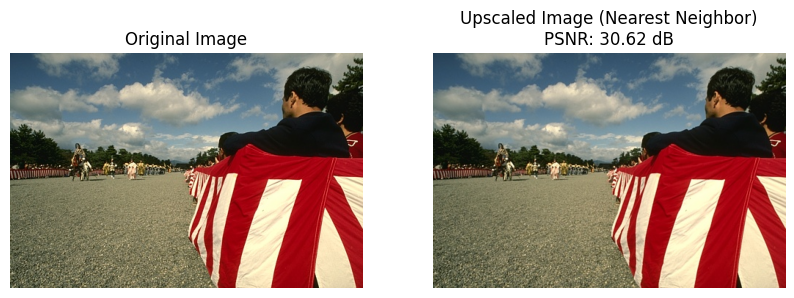

In [16]:
# Calculate PSNR between the resized original image and the upscaled image
psnr_value = psnr(resized_original_image, upscaled_image)

# Display the original and upscaled images using Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Upscaled Image (Nearest Neighbor)\nPSNR: {psnr_value:.2f} dB')
plt.imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


# Image enhancement using GAN Model

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Add, UpSampling2D, Input, LeakyReLU, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Residual Block

Residual Block is used to overcome the degradation problem which means when we add more layers, the performance of the network gets worse instead of better.

In [18]:
# Define the residual block
def residual_block(x):
    filters = 64
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters, kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    return res

# Generator Network
commonly used in tasks like image super-resolution or image-to-image translation. Here with a combination of convolutional, residual, upsampling, and activation layers to transform input data into a desired output, such as high-resolution images.


In [19]:
# Define the generator model
def build_generator(input_shape):
    residual_blocks = 16
    momentum = 0.8
    input_layer = Input(shape=input_shape)

    gen1 = Conv2D(64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    res = gen1
    for _ in range(residual_blocks):
        res = residual_block(res)

    gen2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    gen3 = Add()([gen2, gen1])

    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    gen6 = Conv2D(3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

# Discriminator Network

 discriminator network is designed to classify images as real or fake. It achieves this by applying convolutional operations to extract features from the input images and then using dense layers for classification. The use of LeakyReLU activation functions helps in preventing the network from getting stuck during training, and batch normalization aids in stabilizing the training process.


In [20]:
# Define the discriminator model
def build_discriminator(input_shape):
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_layer = Input(shape=input_shape)

    def discriminator_block(x, filters, strides=1):
        d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
        d = LeakyReLU(alpha=leakyrelu_alpha)(d)
        d = BatchNormalization(momentum=momentum)(d)
        return d

    dis1 = discriminator_block(input_layer, 64, strides=1)
    dis2 = discriminator_block(dis1, 64, strides=2)
    dis3 = discriminator_block(dis2, 128, strides=1)
    dis4 = discriminator_block(dis3, 128, strides=2)
    dis5 = discriminator_block(dis4, 256, strides=1)
    dis6 = discriminator_block(dis5, 256, strides=2)
    dis7 = discriminator_block(dis6, 512, strides=1)
    dis8 = discriminator_block(dis7, 512, strides=2)

    dis9 = Flatten()(dis8)
    dis10 = Dense(units=1024)(dis9)
    dis10 = LeakyReLU(alpha=leakyrelu_alpha)(dis10)

    output = Dense(units=1, activation='sigmoid')(dis10)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

# VGG 19 Network

VGG (Visual Geometry Group) network is a deep convolutional neural network architecture that gained popularity for its simplicity and effectiveness in image recognition tasks. It consists of multiple convolutional layers followed by max-pooling layers, with fully connected layers at the end for classification. VGG typically uses 3x3 convolutional filters with a stride of 1 and a padding of 1 to maintain the spatial resolution. The number of filters in each convolutional layer increases with the depth of the network, leading to a very deep architecture. VGG models come in different variants such as VGG16 and VGG19, which differ in the number of layers. Despite being computationally expensive, VGG networks have been widely used as a benchmark in various computer vision tasks.





In [21]:
# Define the VGG model for feature extraction
def build_vgg(input_shape):
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg.trainable = False
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

# Adversial Network
the adversarial model combines the generator, discriminator, and VGG network. The generator aims to produce high-resolution images from low-resolution inputs, while the discriminator evaluates the generated images. The VGG network helps to capture the content of the generated images. During training, the discriminator's weights are fixed to focus on improving the generator's performance.


In [22]:
# Combine generator, discriminator, and VGG for the adversarial model
def build_adversarial_model(generator, discriminator, vgg, input_shape):
    input_low_resolution = Input(shape=input_shape)
    fake_hr_images = generator(input_low_resolution)
    fake_features = vgg(fake_hr_images)
    discriminator.trainable = False
    validity = discriminator(fake_hr_images)
    model = Model(inputs=[input_low_resolution], outputs=[validity, fake_features])
    return model

In [23]:
# Load and preprocess the dataset
def load_and_preprocess_image(image_path):
    low_res_image = cv2.imread(image_path)
    if low_res_image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    low_res_image = cv2.resize(low_res_image, (64, 64))  # Resize to a fixed size for training
    low_res_image = low_res_image / 127.5 - 1.0
    return low_res_image

In [24]:
# Data generator for training
def data_generator(image_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=image_paths, size=batch_size)
        low_res_images = []
        high_res_images = []
        for path in batch_paths:
            low_res_image = load_and_preprocess_image(path)
            high_res_image = cv2.resize(cv2.imread(path), (256, 256))
            high_res_image = high_res_image / 127.5 - 1.0
            low_res_images.append(low_res_image)
            high_res_images.append(high_res_image)
        yield np.array(low_res_images), np.array(high_res_images)

In [25]:
# Initialize paths and model
dataset_path = '/content/drive/MyDrive/research_dataset/BSD100'
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

generator = build_generator(low_resolution_shape)
discriminator = build_discriminator(high_resolution_shape)
vgg = build_vgg(high_resolution_shape)


80134624/80134624 [==============================] - 0s 0us/step


In [26]:
# Compile models
generator.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
discriminator.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
adversarial_model = build_adversarial_model(generator, discriminator, vgg, low_resolution_shape)
adversarial_model.compile(optimizer=Adam(learning_rate=1e-4), loss=['binary_crossentropy', 'mse'])


In [ ]:
batch_size = 8  # Reduce batch size to lower memory usage
epochs = 1000

# Calculate steps per epoch based on the number of image files
steps_per_epoch = len(image_files) // batch_size

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)

# Training loop
for epoch in range(epochs):
    for step, (low_res_batch, high_res_batch) in enumerate(data_generator(image_files, batch_size)):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Generate high-resolution images
        fake_hr_images = generator.predict(low_res_batch)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(high_res_batch, valid)
        d_loss_fake = discriminator.train_on_batch(fake_hr_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        features = vgg.predict(high_res_batch)
        g_loss = adversarial_model.train_on_batch(low_res_batch, [valid, features])

        if step % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss[0]}]")

    if epoch % 1 == 0:  # Save after each epoch
        # Save generated images and model checkpoints periodically
        enhanced_image = generator.predict(np.expand_dims(low_res_image, axis=0))
        enhanced_image = (enhanced_image + 1.0) * 127.5
        enhanced_image = np.clip(enhanced_image, 0, 255).astype('uint8')

        plt.imshow(cv2.cvtColor(enhanced_image[0], cv2.COLOR_BGR2RGB))
        plt.title(f'Epoch {epoch}')
        plt.axis('off')
        plt.show()

        # Save the model weights
        generator.save(f'generator_epoch_{epoch}.h5')
        discriminator.save(f'discriminator_epoch_{epoch}.h5')
        adversarial_model.save(f'adversarial_model_epoch_{epoch}.h5')


1/1 [==============================] - 2s 2s/step
0 [D loss: 2.1505422592163086 | D accuracy: 50.0] [G loss: 339.3578186035156]
1/1 [==============================] - 0s 23ms/step


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Low-Resolution Image')
plt.imshow(cv2.cvtColor(((low_res_image_input[0] + 1.0) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Enhanced High-Resolution Image\nPSNR: {psnr_value:.2f} dB')
plt.imshow(cv2.cvtColor(enhanced_image[0], cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()